In [1]:
import anndata
import numpy as np
import sys
import torch
sys.path.insert(1, '../../../')
import velovae as vv
%load_ext autoreload
%autoreload 2

In [2]:
dataset = 'BMMC'
root = '/scratch/blaauw_root/blaauw1/gyichen'
adata = anndata.read_h5ad(f'{root}/data/BMMC_pp.h5ad')
adata.obs["clusters"] = adata.obs['celltype.l2'].to_numpy()

In [ ]:
# Uncomment this if data has not been preprocessed
#vv.preprocess(adata, n_gene=2000, min_shared_counts=20, compute_umap=True)
#adata.write_h5ad(f'{root}/data/{dataset}_pp.h5ad')

In [3]:
model_path_base = f'{root}/checkpoints/{dataset}'
figure_path_base = f'{root}/figures/{dataset}'
data_path = f'{root}/data/velovae/continuous/{dataset}'
gene_plot = ['SPINK2', 'AZU1', 'MPO', 'LYZ', 'CD74', 'HBB']

# VeloVAE

In [5]:
figure_path = f'{figure_path_base}/VeloVAE'
model_path = f'{model_path_base}/VeloVAE'

torch.manual_seed(2022)
np.random.seed(2022)

vae = vv.VAE(adata, 
             tmax=20, 
             dim_z=30, 
             device='cuda:0')

vae.train(adata, gene_plot=gene_plot, plot=False, figure_path=figure_path)
vae.save_model(model_path, 'encoder', 'decoder')
vae.save_anndata(adata, 'velovae', data_path, file_name=f'{dataset}.h5ad')

Estimating ODE parameters...


  0%|          | 0/2000 [00:00<?, ?it/s]

Detected 717 velocity genes.
Estimating the variance...


  0%|          | 0/2000 [00:00<?, ?it/s]

Initialization using the steady-state and dynamical models.
Reinitialize the regular ODE parameters based on estimated global latent time.


  0%|          | 0/2000 [00:00<?, ?it/s]

3 clusters detected based on gene co-expression.
(0.59, 0.732014521107534), (0.41, 0.3886589322687619)
(0.68, 0.7303502936602487), (0.32, 0.2898126955613042)
KS-test result: [0. 0. 1.]
Initial induction: 1377, repression: 623/2000
Learning Rate based on Data Sparsity: 0.0005
--------------------------- Train a VeloVAE ---------------------------
*********        Creating Training/Validation Datasets        *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
Total Number of Iterations Per Epoch: 121, test iteration: 240
*********       Stage 1: Early Stop Triggered at epoch 167.       *********
*********                      Stage  2                       *********
*********

  0%|          | 0/22122 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.024
Average Set Size: 446
*********     Round 1: Early Stop Triggered at epoch 310.    *********
Change in noise variance: 0.4332
*********             Velocity Refinement Round 2             *********
*********     Round 2: Early Stop Triggered at epoch 388.    *********
Change in noise variance: 0.0003
Change in x0: 0.0968
*********             Velocity Refinement Round 3             *********
*********     Round 3: Early Stop Triggered at epoch 408.    *********
Change in noise variance: 0.0000
Change in x0: 0.0549
*********             Velocity Refinement Round 4             *********
*********     Round 4: Early Stop Triggered at epoch 508.    *********
Change in noise variance: 0.0000
Change in x0: 0.0482
*********             Velocity Refinement Round 5             *********
Stage 2: Early Stop Triggered at round 4.
*********              Finished. Total Time =   0 h : 27 m : 54 s             *********
Final: Train ELBO = 7321.519,	Test ELBO = 7273.

# Full VB

In [6]:
figure_path = f'{figure_path_base}/FullVB'
model_path = f'{model_path_base}/FullVB'

torch.manual_seed(2022)
np.random.seed(2022)

full_vb = vv.VAE(adata, 
                 tmax=20, 
                 dim_z=30, 
                 device='cuda:0',
                 full_vb=True)

full_vb.train(adata, plot=False, gene_plot=gene_plot, figure_path=figure_path)

full_vb.save_model(model_path, 'encoder', 'decoder')
full_vb.save_anndata(adata, 'fullvb', data_path, file_name=f'{dataset}.h5ad')

Estimating ODE parameters...


  0%|          | 0/2000 [00:00<?, ?it/s]

Detected 717 velocity genes.
Estimating the variance...


  0%|          | 0/2000 [00:00<?, ?it/s]

Initialization using the steady-state and dynamical models.
Reinitialize the regular ODE parameters based on estimated global latent time.


  0%|          | 0/2000 [00:00<?, ?it/s]

3 clusters detected based on gene co-expression.
(0.59, 0.732014521107534), (0.41, 0.3886589322687619)
(0.68, 0.7303502936602487), (0.32, 0.2898126955613042)
KS-test result: [0. 0. 1.]
Initial induction: 1377, repression: 623/2000
Learning Rate based on Data Sparsity: 0.0005
--------------------------- Train a VeloVAE ---------------------------
*********        Creating Training/Validation Datasets        *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
Total Number of Iterations Per Epoch: 121, test iteration: 240
*********       Stage 1: Early Stop Triggered at epoch 135.       *********
*********                      Stage  2                       *********
*********

  0%|          | 0/22122 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.031
Average Set Size: 457
*********     Round 1: Early Stop Triggered at epoch 272.    *********
Change in noise variance: 0.4137
*********             Velocity Refinement Round 2             *********
*********     Round 2: Early Stop Triggered at epoch 312.    *********
Change in noise variance: 0.0006
Change in x0: 0.1814
*********             Velocity Refinement Round 3             *********
*********     Round 3: Early Stop Triggered at epoch 406.    *********
Change in noise variance: 0.0000
Change in x0: 0.1334
*********             Velocity Refinement Round 4             *********
*********     Round 4: Early Stop Triggered at epoch 454.    *********
Change in noise variance: 0.0000
Change in x0: 0.1057
*********             Velocity Refinement Round 5             *********
*********     Round 5: Early Stop Triggered at epoch 532.    *********
Change in noise variance: 0.0000
Change in x0: 0.0805
*********             Velocity Refinement Round 6   

# Plotting

In [2]:
# Uncomment this if you have already pre-computed results
root = '/scratch/blaauw_root/blaauw1/gyichen'
dataset = 'BMMC'
adata = anndata.read_h5ad(f'{root}/data/velovae/continuous/{dataset}/{dataset}_post.h5ad')

In [3]:
Ek = np.median(adata.layers['fullvb_velocity_u']**2 + adata.layers['fullvb_velocity']**2, 0)
gidx = np.argsort(Ek)[-4:]

---   Plotting  Results   ---


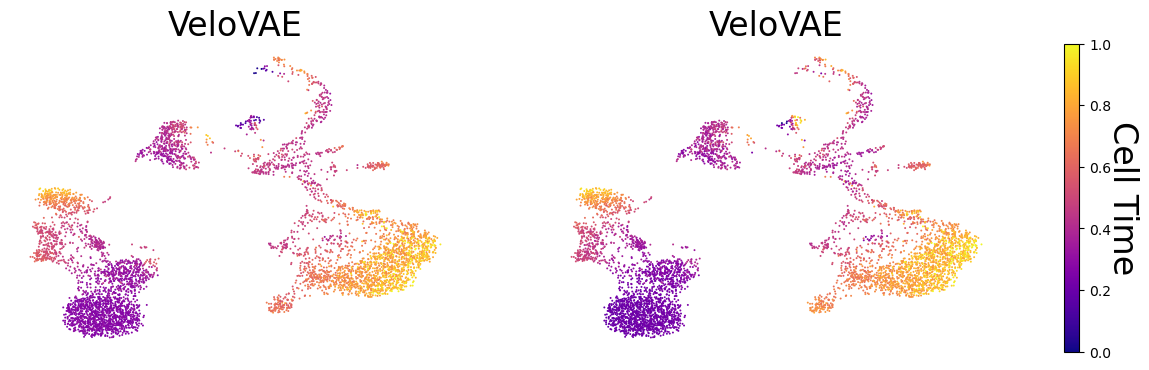

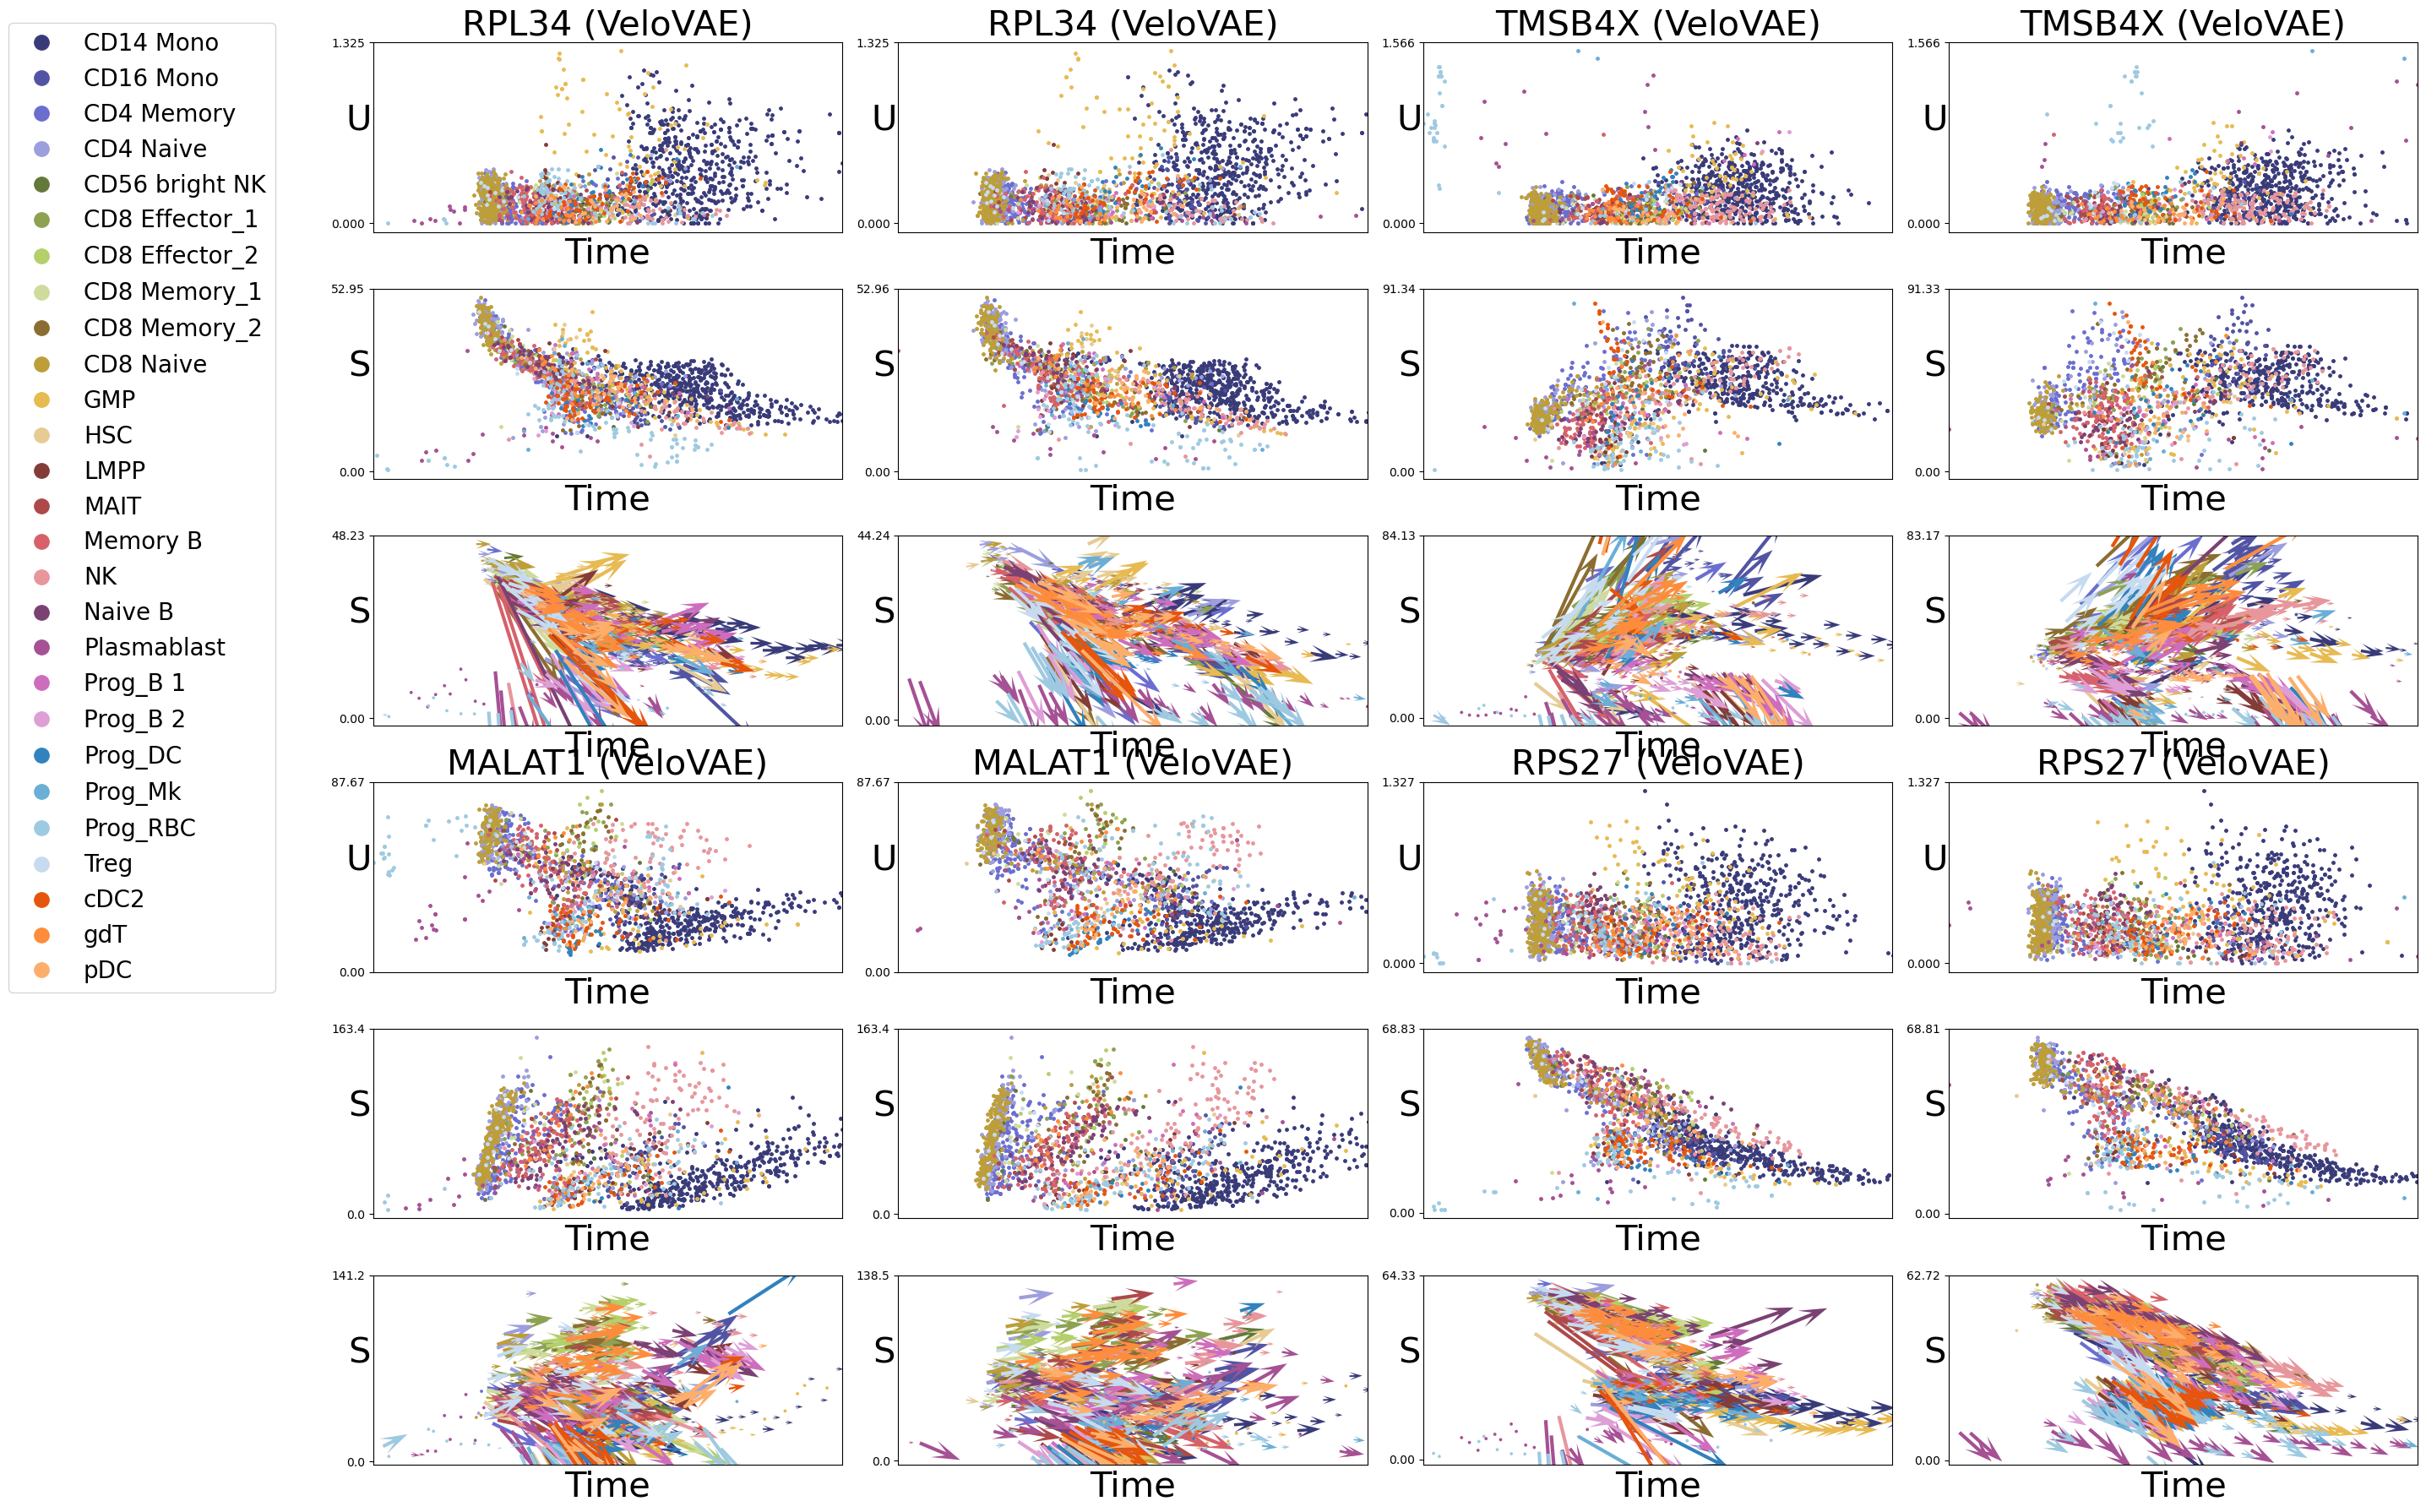

In [4]:
gene_plot = adata.var_names[gidx]
res, res_type = vv.post_analysis(adata,
                                 dataset,
                                 ['VeloVAE', 'FullVB'],
                                 ['velovae', 'fullvb'],
                                 compute_metrics=False,
                                 genes=gene_plot,
                                 plot_type=['time', 'gene'],
                                 grid_size=(2, 2),
                                 figure_path=f'{root}/figures/{dataset}')

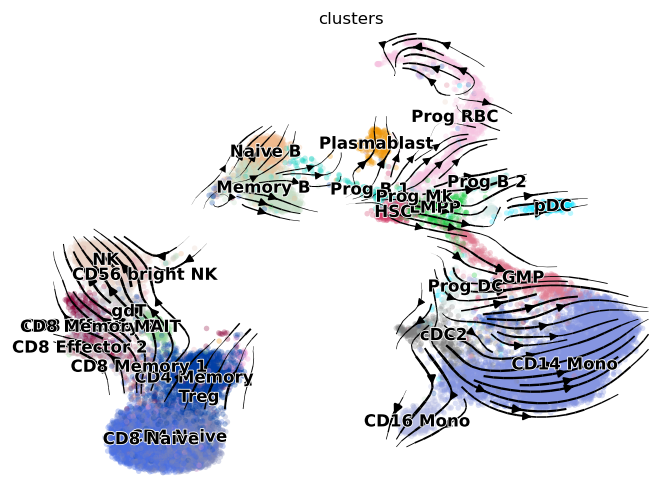

In [5]:
import scvelo as scv
scv.pl.velocity_embedding_stream(adata, vkey='fullvb_velocity', dpi=120)